In [1]:
# import dependencies
import os
import numpy as np
import pandas as pd
import scanpy as sc
import loompy as lp
from MulticoreTSNE import MulticoreTSNE as TSNE

In [2]:
# set variables for file paths to read from and write to:
# set a working directory
wdir = "/Volumes/HOSSAM/Lab-Data/test_run"
os.chdir( wdir )
#path to unfiltered loom file (this will be created in the optional steps below)
f_loom_path_unfilt = "pbmc10k_unfiltered.loom" # test dataset, n=500 cells

# # path to loom file with basic filtering applied (this will be created in the "initial filtering" step below). Optional.
f_loom_path_scenic = "pbmc10k_filtered_scenic.loom"

# path to anndata object, which will be updated to store Scanpy results as they are generated below
f_anndata_path = "anndata.h5ad"

# path to pyscenic output
f_pyscenic_output = "pyscenic_output.loom"

# loom output, generated from a combination of Scanpy and pySCENIC results:
f_final_loom = 'pbmc10k_scenic_integrated-output.loom'

In [3]:
sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.set_figure_params(dpi=150, fontsize=10, dpi_save=600)

-----
anndata     0.7.5
scanpy      1.6.0
sinfo       0.3.1
-----
MulticoreTSNE       NA
PIL                 7.0.0
anndata             0.7.5
appnope             0.1.0
backcall            0.1.0
cffi                1.14.0
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.1
decorator           4.4.1
get_version         2.1
google              NA
h5py                2.10.0
importlib_metadata  1.6.1
ipykernel           5.3.0
ipython_genutils    0.2.0
jedi                0.13.3
joblib              0.14.1
kiwisolver          1.1.0
legacy_api_wrap     1.2
llvmlite            0.34.0
loompy              3.0.6
matplotlib          3.1.2
mpl_toolkits        NA
natsort             7.1.0
numba               0.51.2
numexpr             2.7.1
numpy               1.18.1
numpy_groupies      0.9.13
packaging           20.4
pandas              1.0.5
parso               0.4.0
pexpect             4.7.0
pickleshare         0.7.5
pkg_resources       NA
prompt_toolkit      2.0.9
ptyproces

In [4]:
#max jobs for scanpy
sc.settings.njobs = 20

## Expression Data Import

Will be using 10x Genomics mtx files. Similar to Seurat Read10x

In [5]:
test_dir = '/Volumes/HOSSAM/Lab-Data/filtered_feature_bc_matrix'

adata = sc.read_10x_mtx(test_dir, var_names='gene_symbols')

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


In [9]:
adata
adata.var

,gene_ids,feature_types
MIR1302-2HG,ENSG00000243485,Gene Expression
FAM138A,ENSG00000237613,Gene Expression
OR4F5,ENSG00000186092,Gene Expression
AL627309.1,ENSG00000238009,Gene Expression
AL627309.3,ENSG00000239945,Gene Expression
...,...,...
AC233755.2,ENSG00000277856,Gene Expression
AC233755.1,ENSG00000275063,Gene Expression
AC240274.1,ENSG00000271254,Gene Expression
AC213203.1,ENSG00000277475,Gene Expression


In [10]:
row_attrs = { 
    "Gene": np.array(adata.var.index) ,
}
col_attrs = { 
    "CellID":  np.array(adata.obs.index) ,
    "nGene": np.array( np.sum(adata.X.transpose()>0 , axis=0)).flatten() , #numbmer of reads?
    "nUMI": np.array( np.sum(adata.X.transpose() , axis=0)).flatten() , #unique molecular identifier
}

lp.create( f_loom_path_unfilt, adata.X.transpose(), row_attrs, col_attrs )

In [6]:
row_attrs

{'Gene': array(['LOC105439897', 'LOC105436482', 'LOC764781', ..., 'trnag-ucc-32',
        'LOC582726', 'LOC100893868'], dtype=object)}

In [7]:
col_attrs

{'CellID': array(['AAACGCTGTGTACATC-1', 'AAACGCTTCCAGTGTA-1', 'AAAGGATGTTTACGTG-1',
        'AAAGGTATCAGGAAAT-1', 'AAAGTCCAGCTCGAAG-1', 'AAATGGAAGTGATAAC-1',
        'AACAAAGCAAATACGA-1', 'AACAACCAGTATGCAA-1', 'AACAAGACACTTGTGA-1',
        'AACACACAGTGCAACG-1', 'AACACACTCAGACATC-1', 'AACAGGGAGCTAGCCC-1',
        'AACAGGGCACACAGCC-1', 'AACCAACGTGAGATTA-1', 'AACCCAACATGACACT-1',
        'AACCCAAGTCGTACAT-1', 'AACCTGACACTATCGA-1', 'AACGAAAGTTGTCTAG-1',
        'AACGTCAAGGGATCTG-1', 'AACGTCACATGGGTTT-1', 'AACGTCATCGCTGACG-1',
        'AACTTCTAGGAATCGC-1', 'AACTTCTCATACACCA-1', 'AACTTCTGTGAATGTA-1',
        'AAGAACAAGCGGATCA-1', 'AAGACAATCCGATCTC-1', 'AAGACAATCTGCTCTG-1',
        'AAGACTCCAGAGGTAC-1', 'AAGATAGAGCAAGCCA-1', 'AAGATAGTCCTGATAG-1',
        'AAGCATCAGGCTCTAT-1', 'AAGCCATGTACAAAGT-1', 'AAGCGTTCAACCAGAG-1',
        'AAGCGTTCACCCTTGT-1', 'AAGGAATGTGACCTGC-1', 'AAGGTAAAGTAGGCCA-1',
        'AAGTACCTCCCACAGG-1', 'AAGTCGTGTCGACTGC-1', 'AAGTGAACACGCGTCA-1',
        'AAGTGAATCCGGTAAT-1'

## Basic Filtering

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

In [14]:
adata = sc.read_loom(f_loom_path_unfilt)

In [15]:
nCountsPerGene = np.sum(adata.X, axis=0)
nCellsPerGene = np.sum(adata.X>0, axis=0)

# Show info
print("Number of counts (in the dataset units) per gene:", nCountsPerGene.min(), " - " ,nCountsPerGene.max())
print("Number of cells in which each gene is detected:", nCellsPerGene.min(), " - " ,nCellsPerGene.max())

Number of counts (in the dataset units) per gene: 0.0  -  3567008.0
Number of cells in which each gene is detected: 0  -  11766


In [16]:
adata

AnnData object with n_obs × n_vars = 11769 × 33538
    obs: 'nGene', 'nUMI'

In [17]:
nCells=adata.X.shape[0]

# pySCENIC thresholds
minCountsPerGene=3*.01*nCells # 3 counts in 1% of cells
print("minCountsPerGene: ", minCountsPerGene)

minSamples=.01*nCells # 1% of cells
print("minSamples: ", minSamples)

minCountsPerGene:  353.07
minSamples:  117.69


In [21]:
adata.var_names

Index(['MIR1302-2HG', 'FAM138A', 'OR4F5', 'AL627309.1', 'AL627309.3',
       'AL627309.2', 'AL627309.4', 'AL732372.1', 'OR4F29', 'AC114498.1',
       ...
       'AC007325.2', 'BX072566.1', 'AL354822.1', 'AC023491.2', 'AC004556.1',
       'AC233755.2', 'AC233755.1', 'AC240274.1', 'AC213203.1', 'FAM231C'],
      dtype='object', length=33538)

In [33]:
# simply compute the number of genes per cell (computes 'n_genes' column)
sc.pp.filter_cells(adata, min_genes=0)
# mito and genes/counts cuts
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# .A1 is to return a flattened array
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1 
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

### Diagnostics plots, prefiltering

Number of Genes expressed per cell

Left Plot --> Full histogram of number of genes in each cell
Middle plot --> Lower bound of the histogram
Right Plot --> Upper bound of histogram

In [34]:
adata.obs['n_genes']

AAACCCAAGCGCCCAT-1    1087
AAACCCAAGGTTCCGC-1    4200
AAACCCACAGAGTTGG-1    1836
AAACCCACAGGTATGG-1    2216
AAACCCACATAGTCAC-1    1615
                      ... 
TTTGTTGGTGTCATGT-1    1331
TTTGTTGGTTTGAACC-1    1401
TTTGTTGTCCAAGCCG-1    1668
TTTGTTGTCTTACTGT-1    1745
TTTGTTGTCTTCTAAC-1     698
Name: n_genes, Length: 11769, dtype: int64

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your c

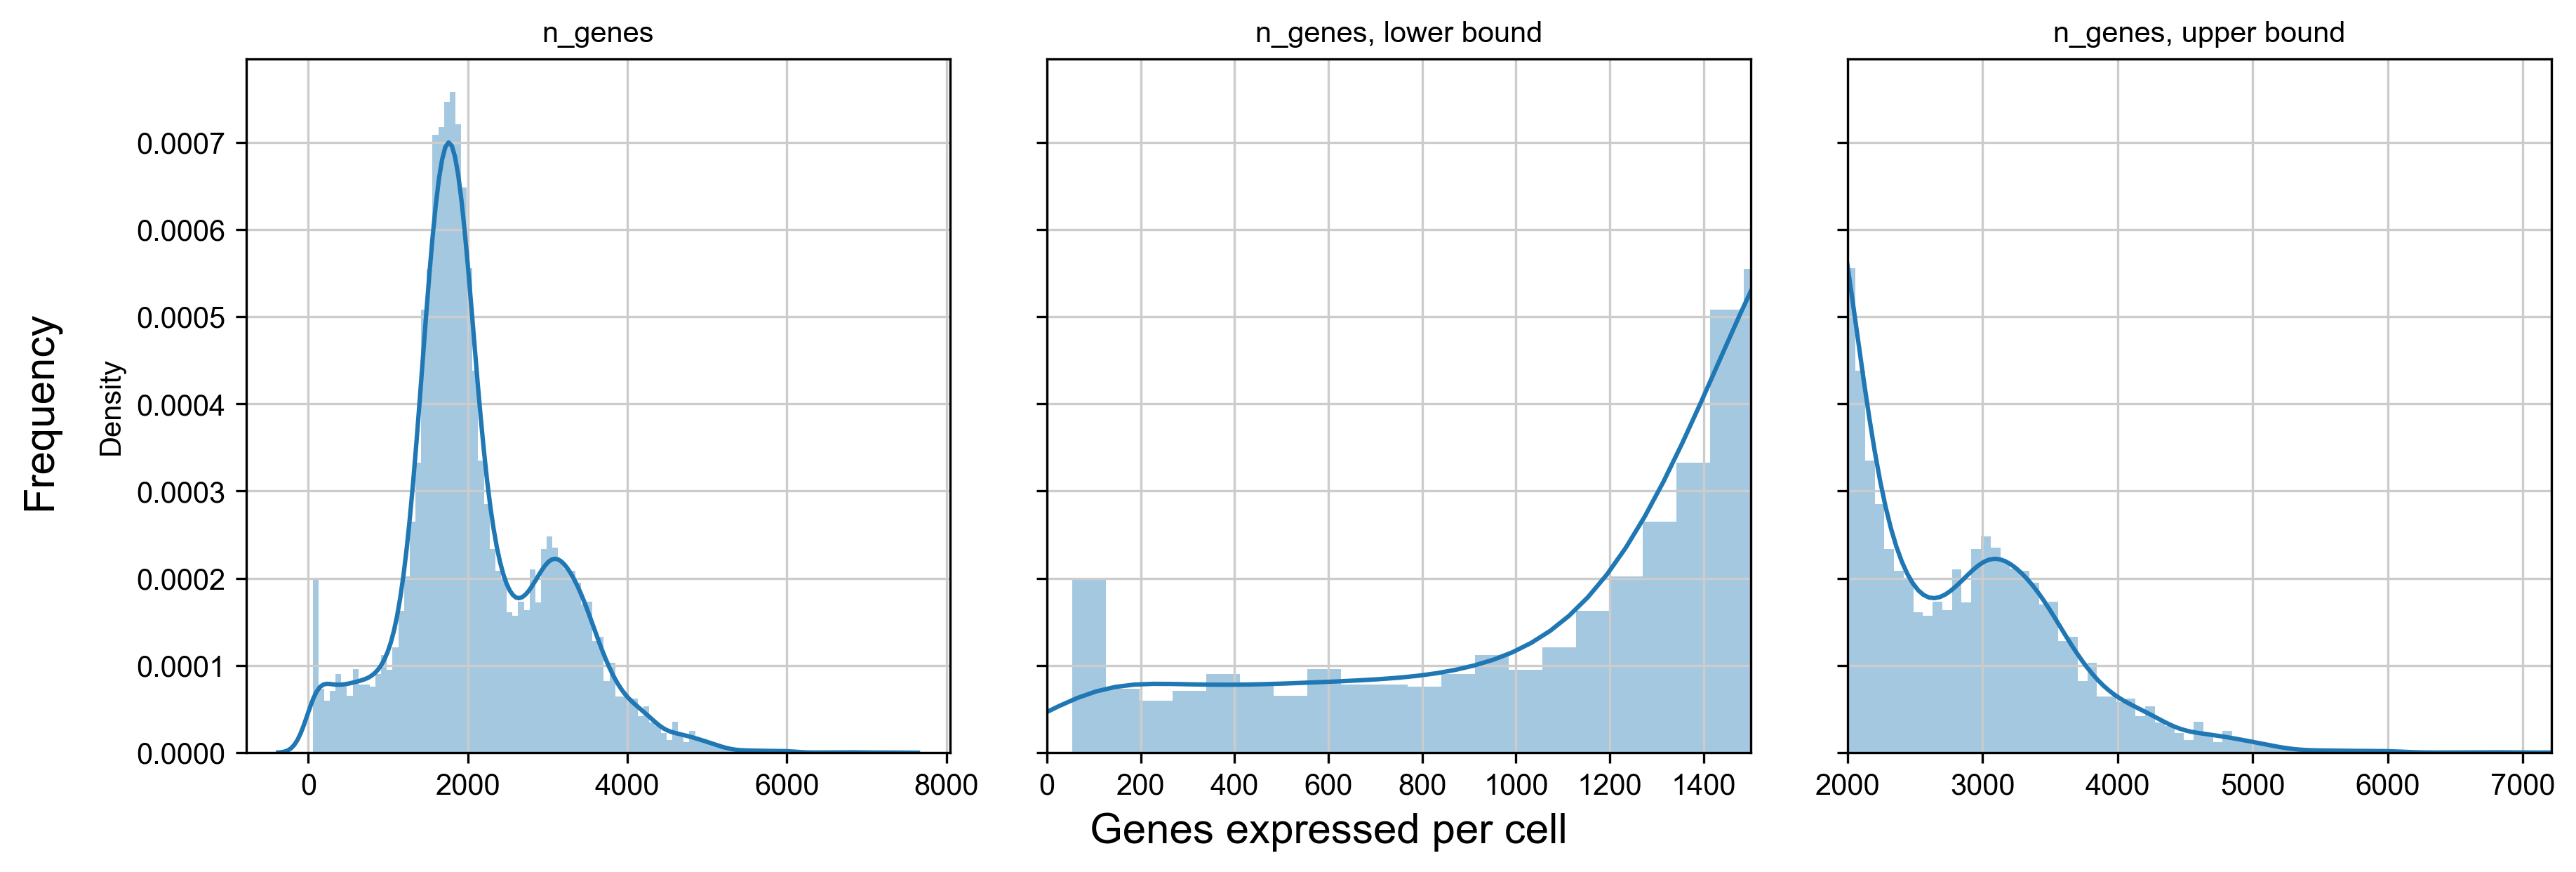

In [35]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=True)

x = adata.obs['n_genes']
x_lowerbound = 1500
x_upperbound = 2000
nbins=100

sns.distplot(x, ax=ax1, norm_hist=True, bins=nbins)
sns.distplot(x, ax=ax2, norm_hist=True, bins=nbins)
sns.distplot(x, ax=ax3, norm_hist=True, bins=nbins)

ax2.set_xlim(0,x_lowerbound)
ax3.set_xlim(x_upperbound, adata.obs['n_genes'].max() )

for ax in (ax1,ax2,ax3): 
  ax.set_xlabel('')

ax1.title.set_text('n_genes')
ax2.title.set_text('n_genes, lower bound')
ax3.title.set_text('n_genes, upper bound')

fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')
fig.text(0.5, 0.0, 'Genes expressed per cell', ha='center', va='center', size='x-large')

fig.tight_layout()

Percent of mitochondrial reads per cell

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your c

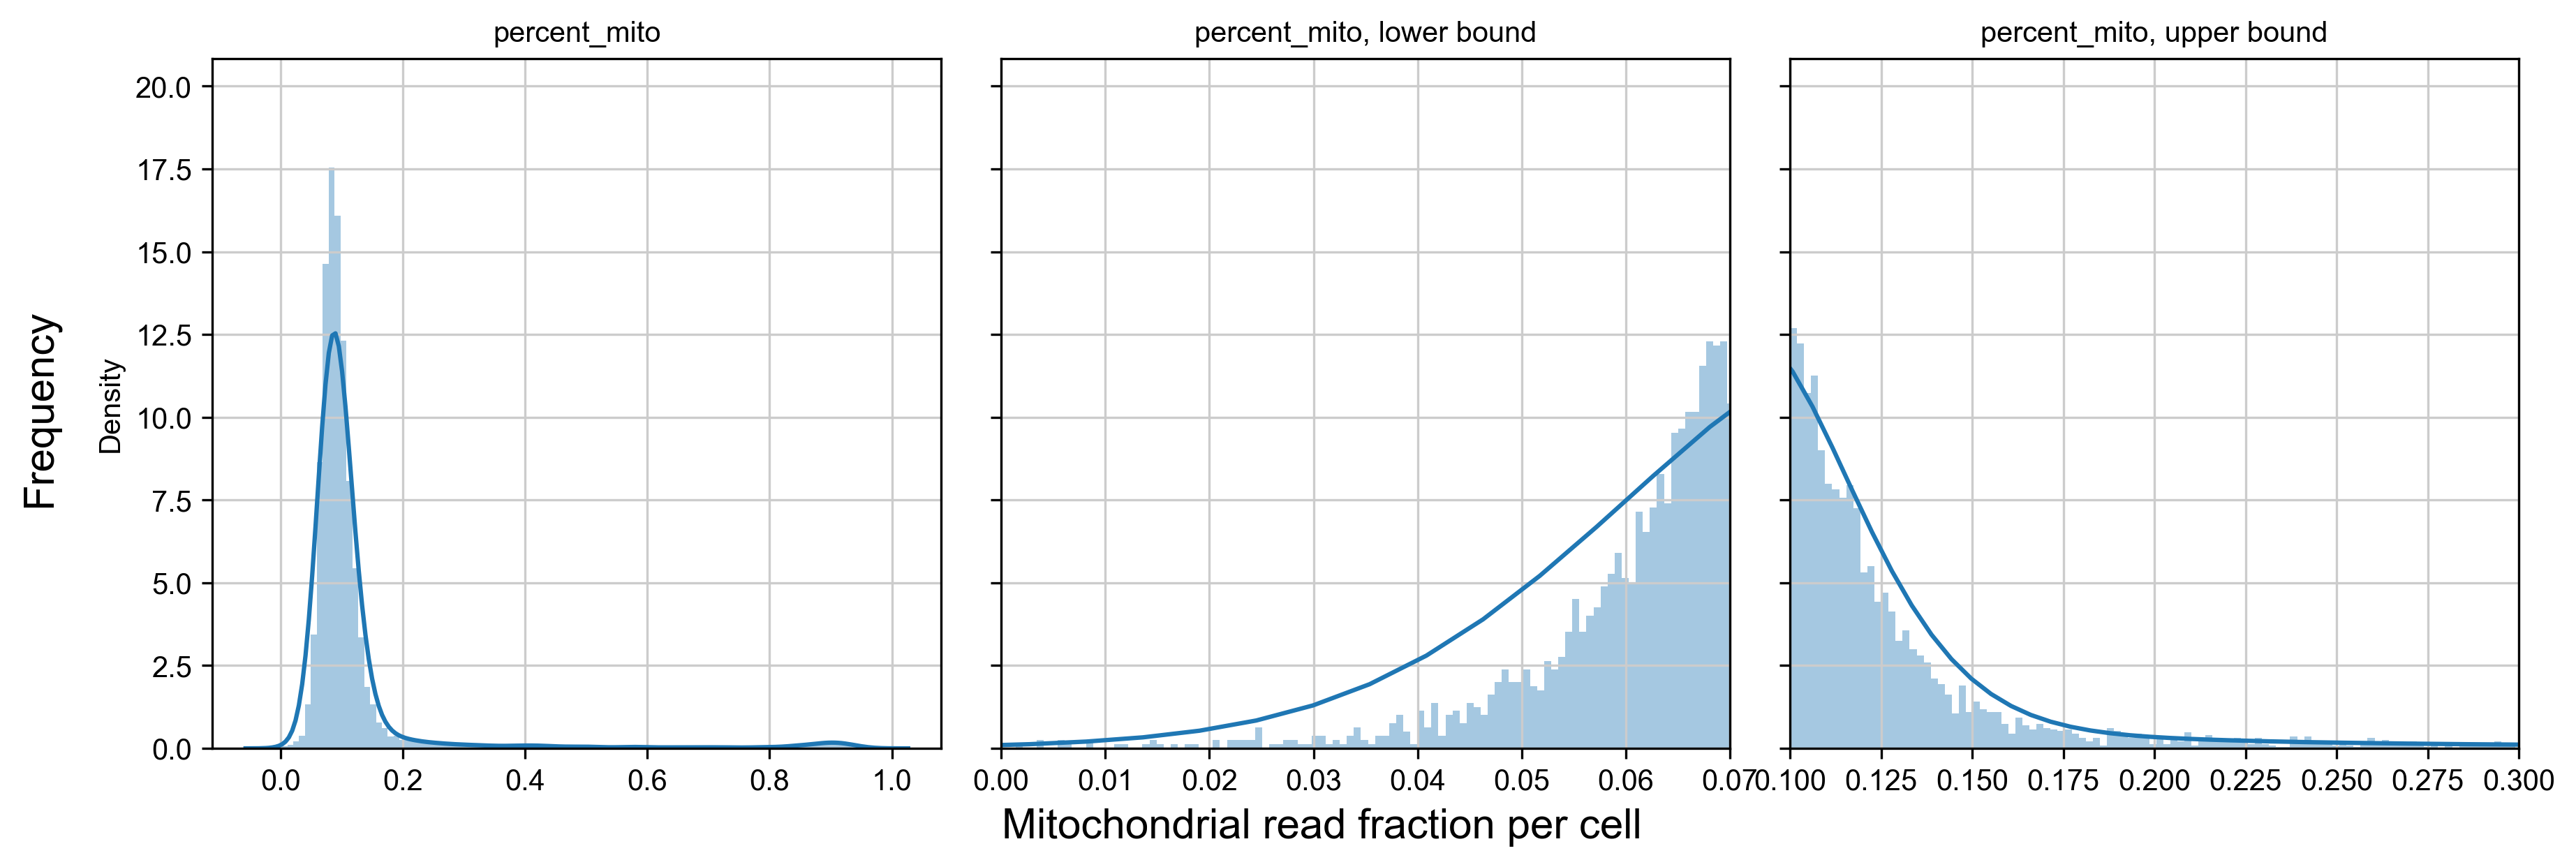

In [36]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=True)

x = adata.obs['percent_mito']
x_lowerbound = [0.0, 0.07 ]
x_upperbound = [ 0.10, 0.3 ]
nbins=100

sns.distplot(x, ax=ax1, norm_hist=True, bins=nbins)
sns.distplot(x, ax=ax2, norm_hist=True, bins=int(nbins/(x_lowerbound[1]-x_lowerbound[0])) )
sns.distplot(x, ax=ax3, norm_hist=True, bins=int(nbins/(x_upperbound[1]-x_upperbound[0])) )

ax2.set_xlim(x_lowerbound[0], x_lowerbound[1])
ax3.set_xlim(x_upperbound[0], x_upperbound[1] )
for ax in (ax1,ax2,ax3): 
  ax.set_xlabel('')

ax1.title.set_text('percent_mito')
ax2.title.set_text('percent_mito, lower bound')
ax3.title.set_text('percent_mito, upper bound')

fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')
fig.text(0.5, 0.0, 'Mitochondrial read fraction per cell', ha='center', va='center', size='x-large')

fig.tight_layout()

Three Panel Summary plot

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your c

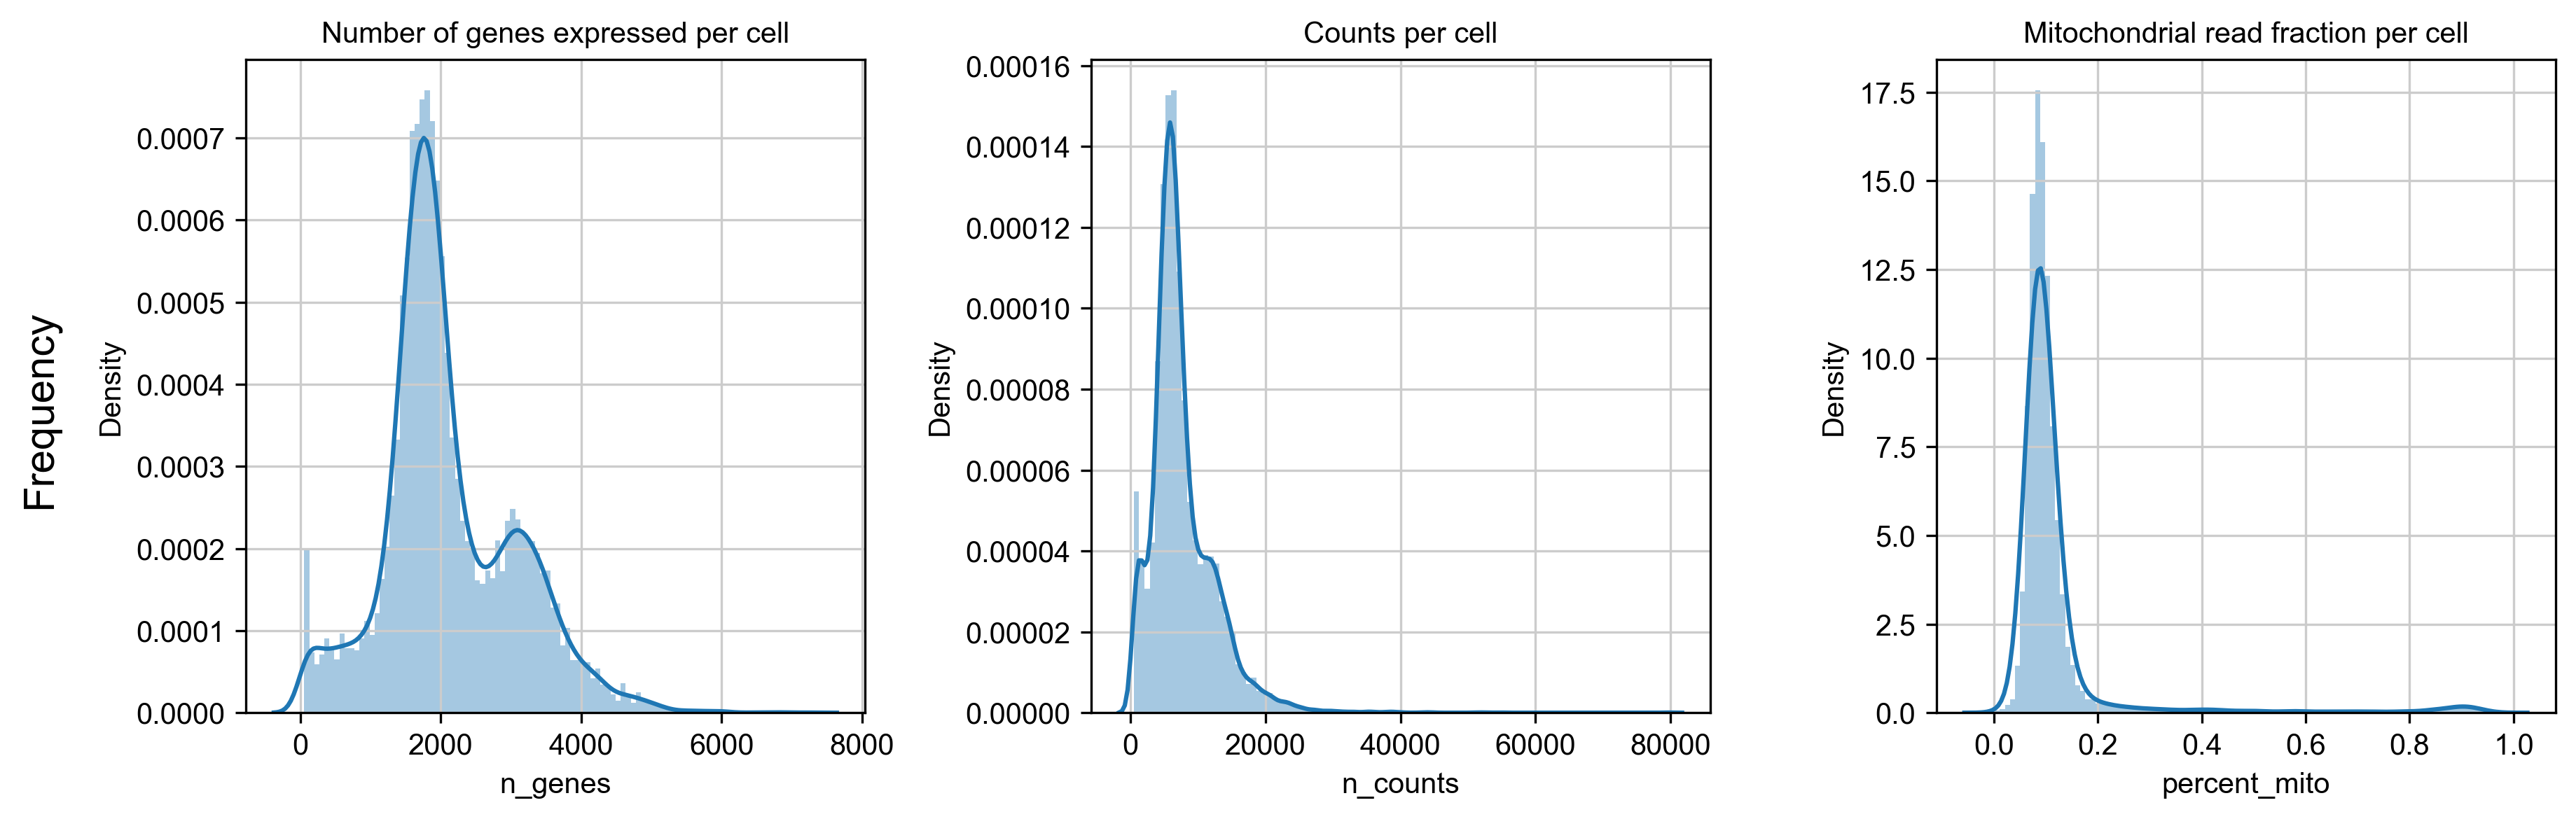

In [37]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=False)

sns.distplot( adata.obs['n_genes'], ax=ax1, norm_hist=True, bins=100)
sns.distplot( adata.obs['n_counts'], ax=ax2, norm_hist=True, bins=100)
sns.distplot( adata.obs['percent_mito'], ax=ax3, norm_hist=True, bins=100)

ax1.title.set_text('Number of genes expressed per cell')
ax2.title.set_text('Counts per cell')
ax3.title.set_text('Mitochondrial read fraction per cell')

fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')

fig.tight_layout()


### Violin plots

Left --> Number of genes expressed in each cell
Right --> Number of sequences from each cell
Right --> Percent of mitochondrial reads in each cell

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


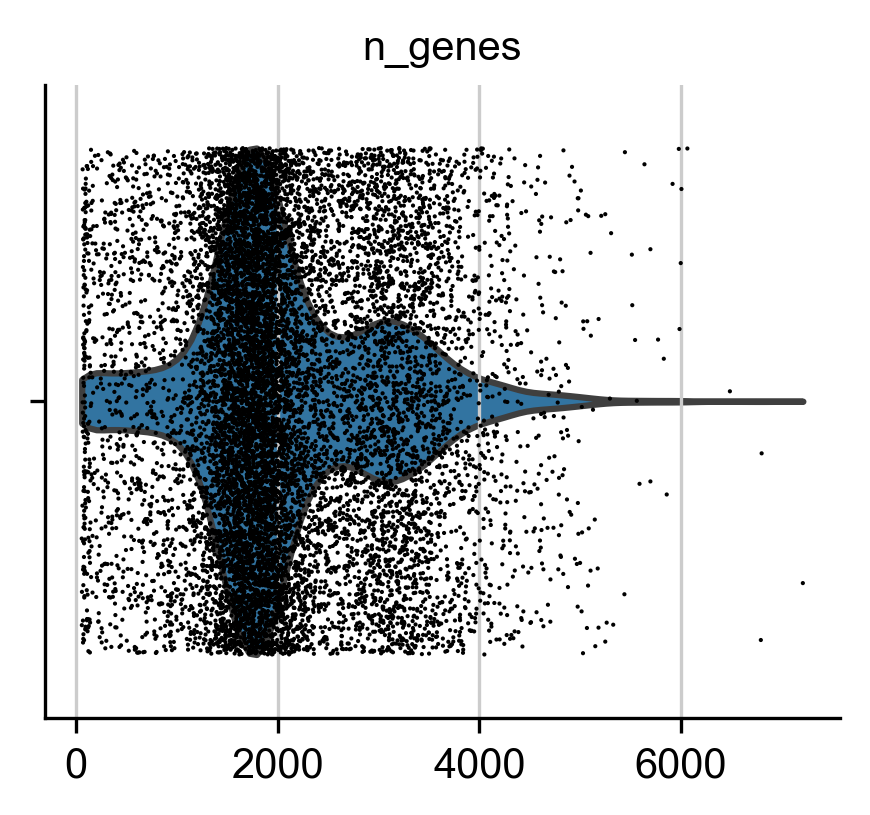

In [50]:
sc.pl.violin(adata, ['n_genes'],
    jitter=0.4, multi_panel=True)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


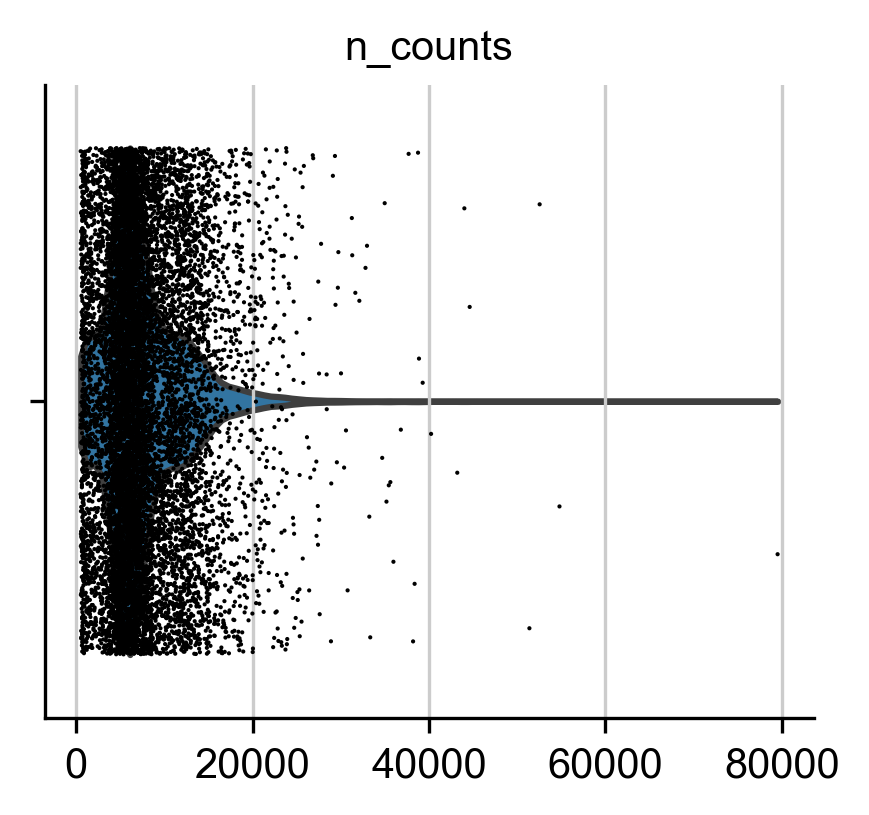

In [51]:
sc.pl.violin(adata, ['n_counts'],
    jitter=0.4, multi_panel=True)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


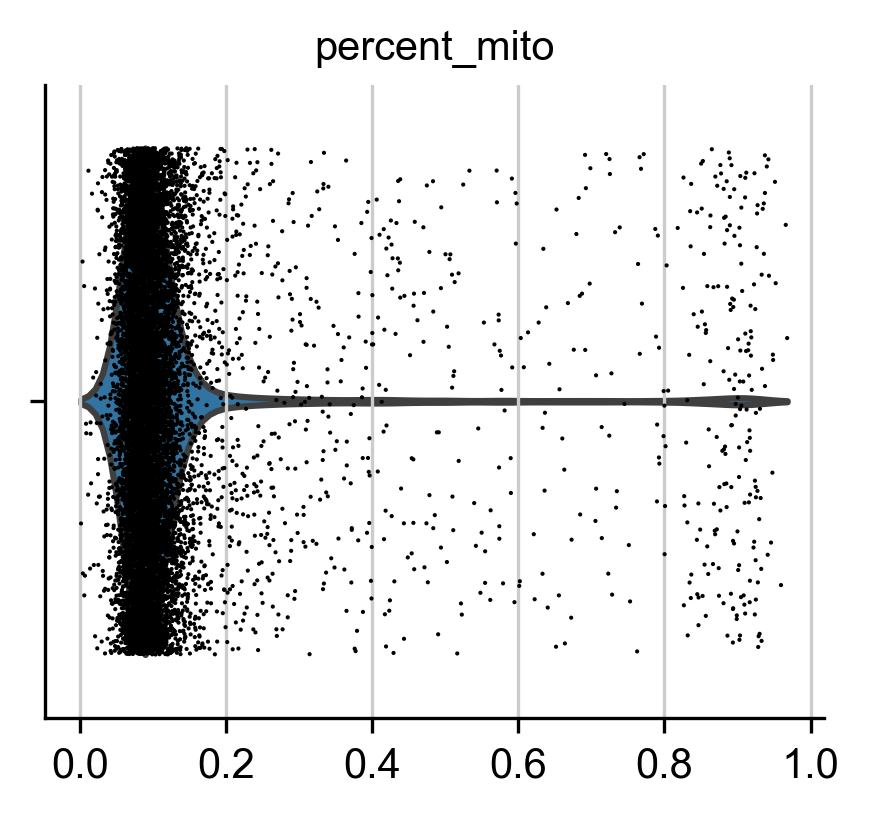

In [52]:
sc.pl.violin(adata, ['percent_mito'],
    jitter=0.4, multi_panel=True)

Scatter plot, number of counts on x, number of genes on Y, and the percent of mitochondrial genes will be depending on the color

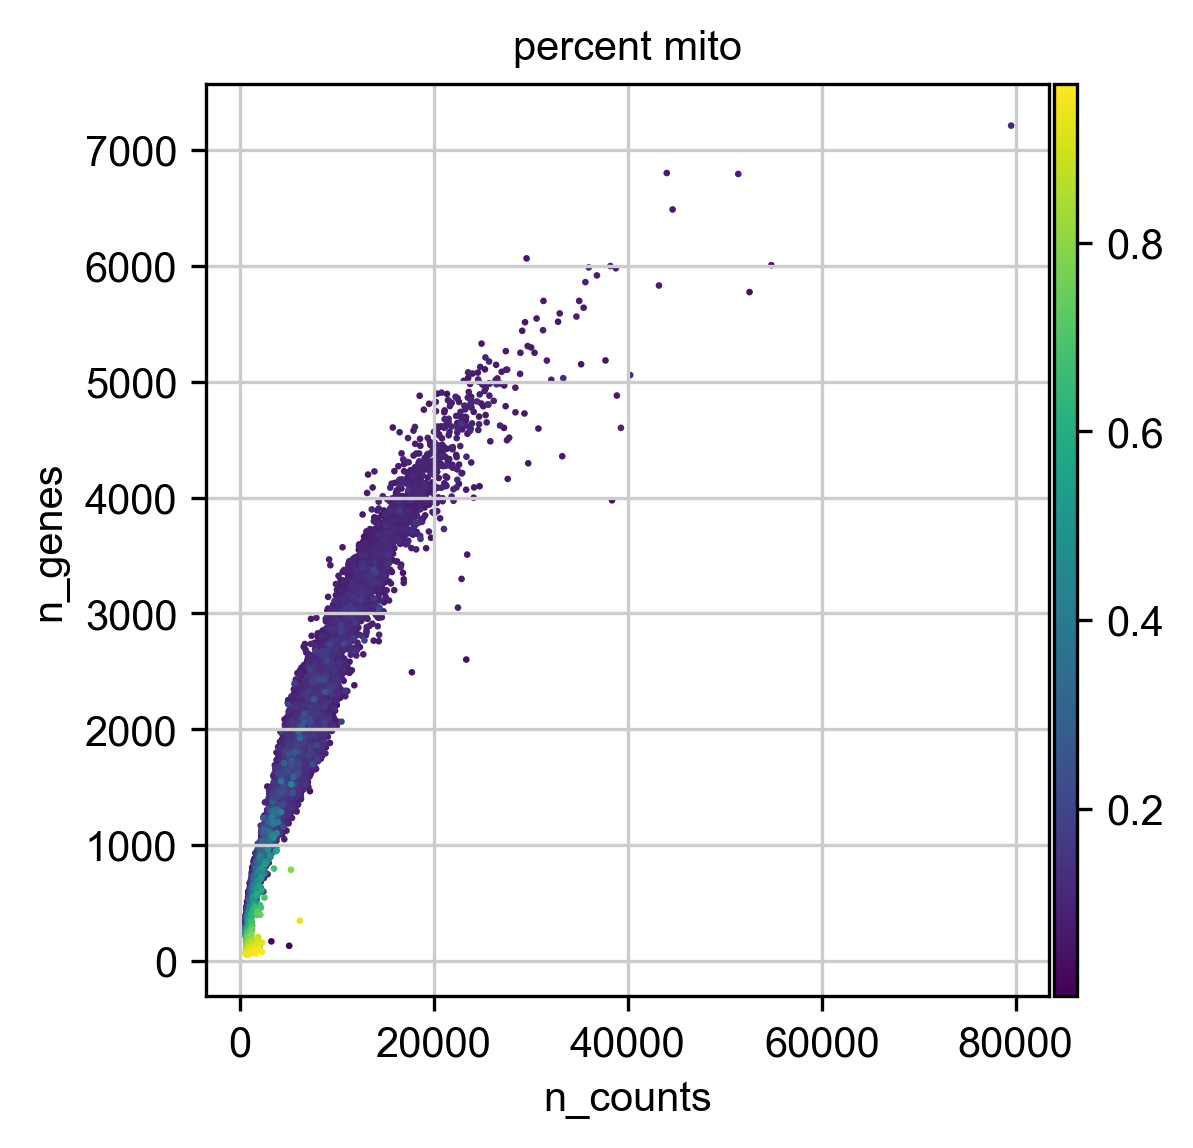

In [53]:
sc.pl.scatter(adata, x='n_counts', y='n_genes', color='percent_mito')

Carry out filtering

In [54]:
# initial cuts
sc.pp.filter_cells(adata, min_genes=200 )
sc.pp.filter_genes(adata, min_cells=3 )

filtered out 232 cells that have less than 200 genes expressed
filtered out 13246 genes that are detected in less than 3 cells


In [55]:
adata = adata[adata.obs['n_genes'] < 4000, :] #filters cells where number of genes is more than 40000
adata = adata[adata.obs['percent_mito'] < 0.15, :] #filters cells where percent of mitchondrial genes expressed is more than .15

### Post Filtering

Summary Plots

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your c

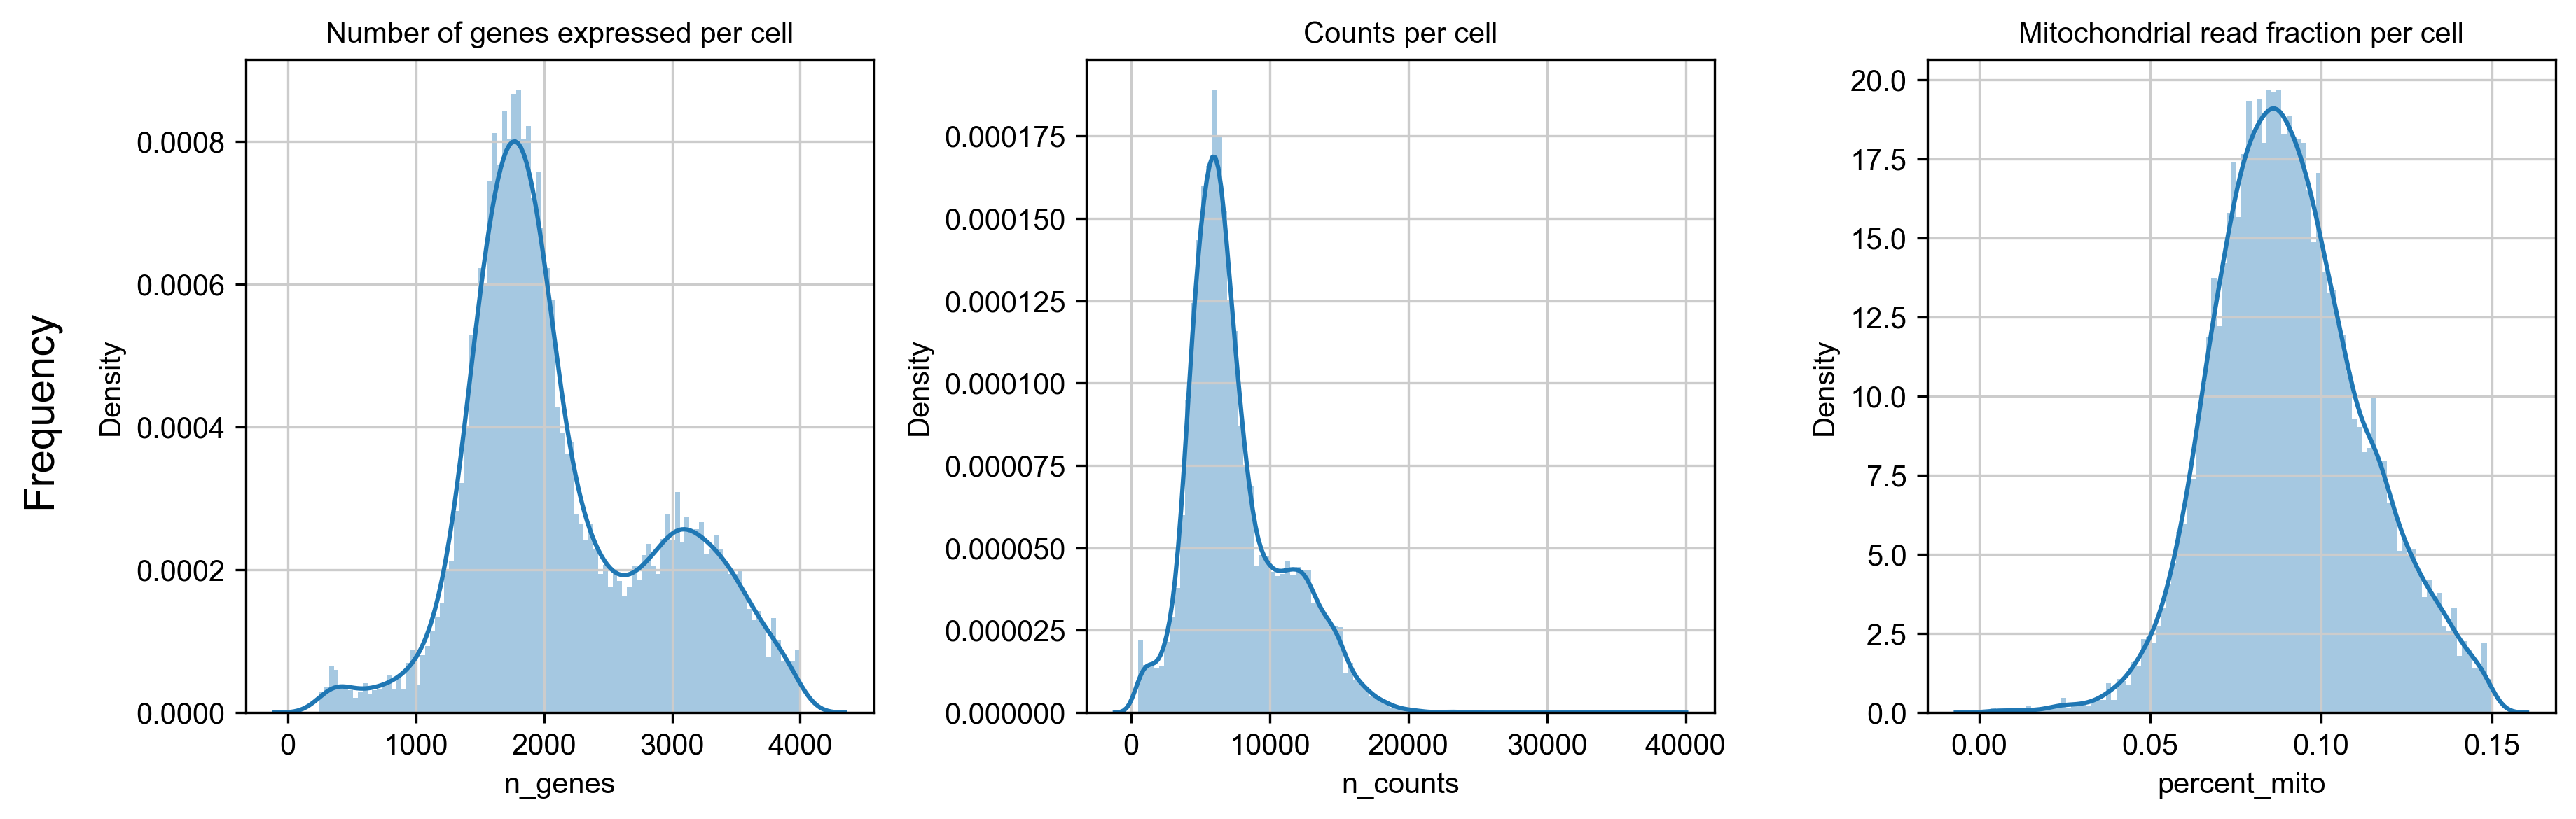

In [57]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=False)

adata.obs['n_genes']

sns.distplot( adata.obs['n_genes'], ax=ax1, norm_hist=True, bins=100)
sns.distplot( adata.obs['n_counts'], ax=ax2, norm_hist=True, bins=100)
sns.distplot( adata.obs['percent_mito'], ax=ax3, norm_hist=True, bins=100)

ax1.title.set_text('Number of genes expressed per cell')
ax2.title.set_text('Counts per cell')
ax3.title.set_text('Mitochondrial read fraction per cell')

fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')

fig.tight_layout()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


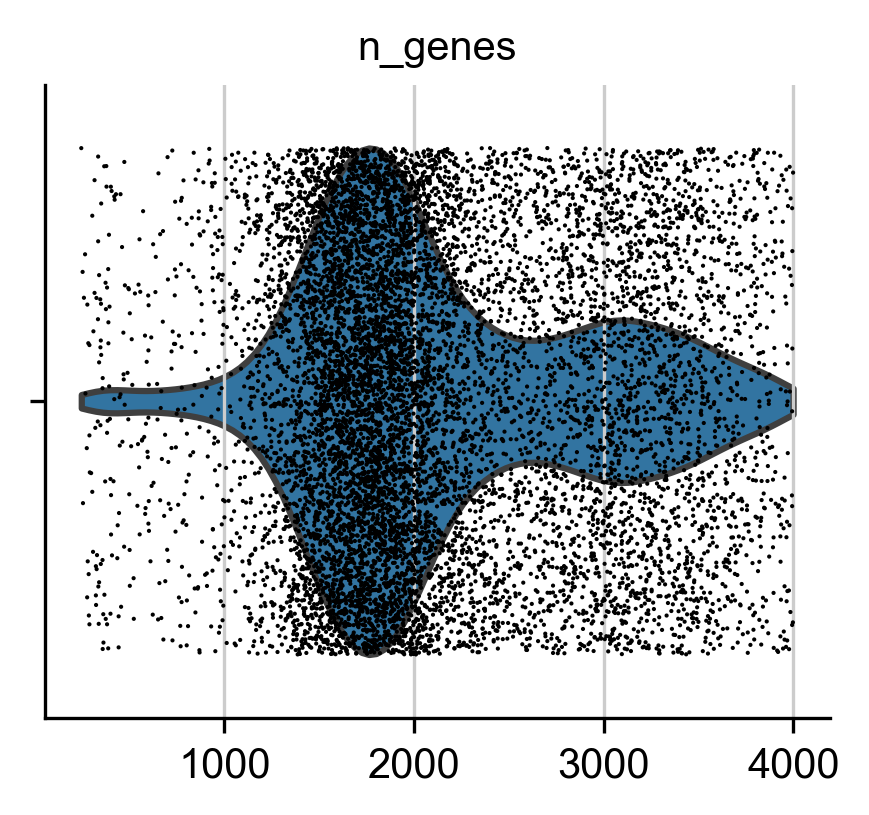

In [58]:
sc.pl.violin(adata, ['n_genes'],
    jitter=0.4, multi_panel=True )

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


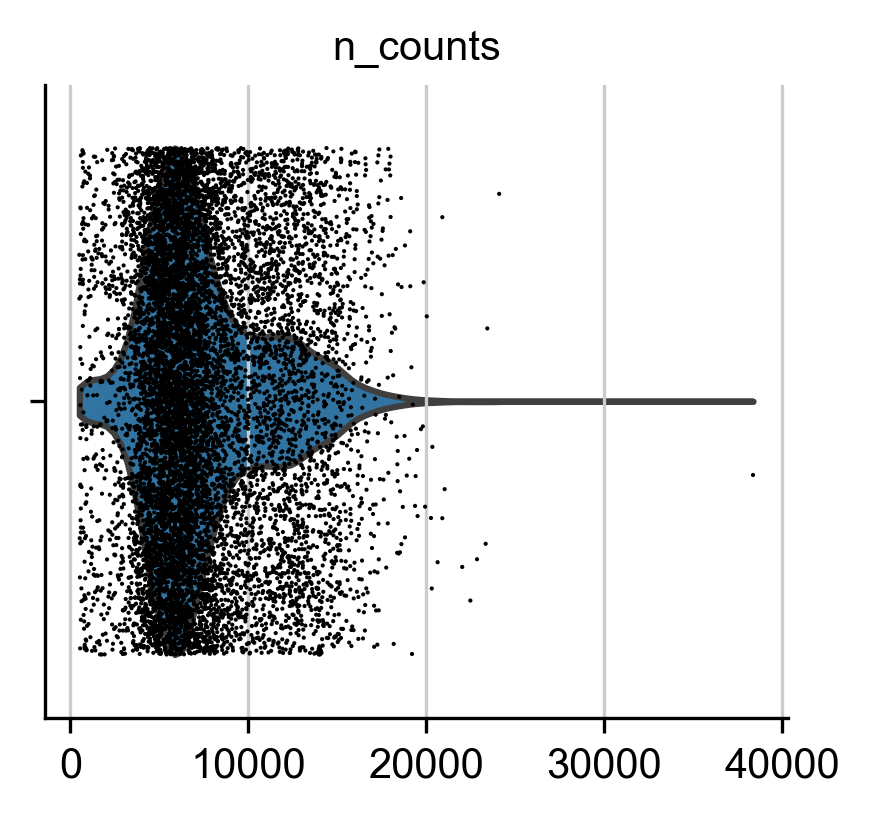

In [59]:
sc.pl.violin(adata, ['n_counts'],
    jitter=0.4, multi_panel=True )

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


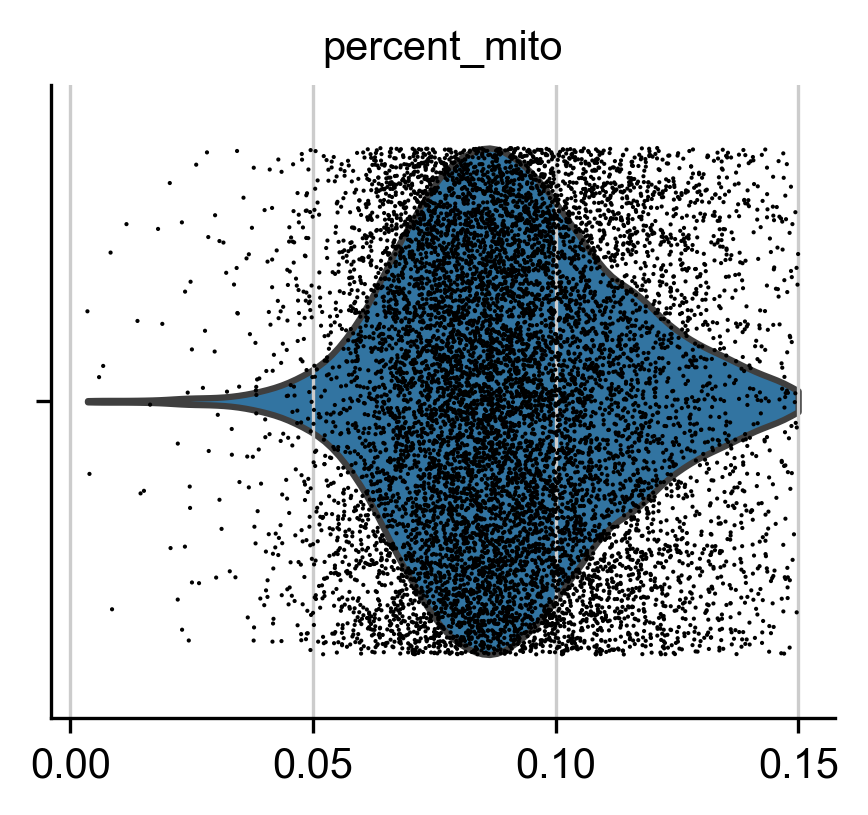

In [60]:
sc.pl.violin(adata, ['percent_mito'],
    jitter=0.4, multi_panel=True )

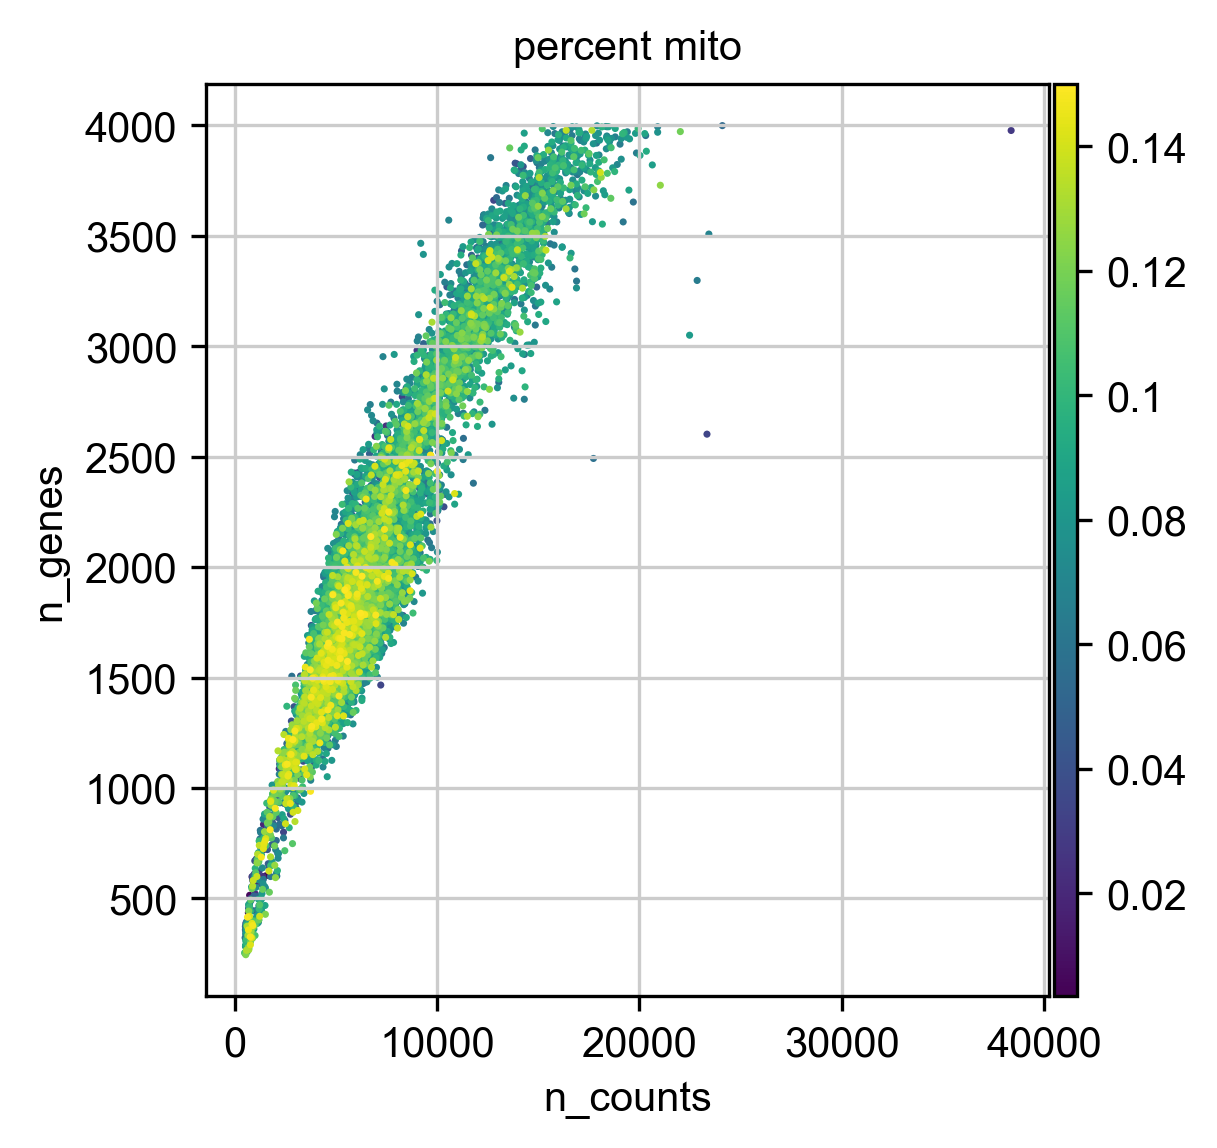

In [61]:
sc.pl.scatter(adata, x='n_counts', y='n_genes', color='percent_mito')
